<a href="https://colab.research.google.com/github/azizghozi25/Covid19-Prediction-with-RNN/blob/main/Prediksi_Covid_19_Mengggunakan_Recurrent_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Akhdan Aziz Ghozi - Mathematics


---


This notebook is a big assignment of Komputasi Matematika 3 when I were studying at mathematics department of Institut Teknologi Sumatera. I share this notebook to public in order to share my understanding and obtain if any feedback in order to improve my skills. 

So, I assigned by my lecturer to predict a case with one of deep learning methods that we have learned before. I have chosen 3 datas about Covid-19 in Lampung Province, those are active case, recovered case, and death case. Besides that, i have chosen Recurrent Neural Network (RNN) Method because RNN is a fprm of artificial neural network architecture designed specifically for processing time series data. RNN can store memory (feedback loop) so that it can recognize data patterns well and then use then to make accurate prediction.

There are severel steps that will be done:


1.   Step 1 - Loading Data
2.   Step 2 - Pre-processing
3.   Step 3 - Preparing Model
4.   Step 4 - Data Normalization
5.   Step 5 - Training Model
6.   Step 6 - Prediction

# Step 1- Loading Data
First, we have to prepare some library that we need. As the main library that handles the prediction part we used library Keras from Tensorflow and the support library used are Numpy, Pandas and Matplotlib.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn
import math
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Data Covid-19 obtained from https://data.covid19.go.id . Using this website we can obtain the actual datas that updated by day. 

In [2]:
import requests
resp_lampung = requests.get('https://data.covid19.go.id/public/api/prov_detail_LAMPUNG.json')
cov_lampung = resp_lampung.json()


In [3]:
print('elemen utama:\n', cov_lampung.keys())

elemen utama:
 dict_keys(['last_date', 'provinsi', 'kasus_total', 'kasus_tanpa_tgl', 'kasus_dengan_tgl', 'meninggal_persen', 'meninggal_tanpa_tgl', 'meninggal_dengan_tgl', 'sembuh_persen', 'sembuh_tanpa_tgl', 'sembuh_dengan_tgl', 'list_perkembangan', 'data'])


In [4]:
print('\n Jumlah total kasus di Lampung   : %d' %cov_lampung['kasus_total'])


 Jumlah total kasus di Lampung   : 74529


In [5]:
cov_lampung = pd.DataFrame(cov_lampung['list_perkembangan'])
cov_lampung.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   tanggal                       834 non-null    int64
 1   KASUS                         834 non-null    int64
 2   MENINGGAL                     834 non-null    int64
 3   SEMBUH                        834 non-null    int64
 4   DIRAWAT_OR_ISOLASI            834 non-null    int64
 5   AKUMULASI_KASUS               834 non-null    int64
 6   AKUMULASI_SEMBUH              834 non-null    int64
 7   AKUMULASI_MENINGGAL           834 non-null    int64
 8   AKUMULASI_DIRAWAT_OR_ISOLASI  834 non-null    int64
dtypes: int64(9)
memory usage: 58.8 KB


# Step 2 - Pre-processing


to make processing data easier, we change our keys to lower and make one column named 'tanggal' in order to make easier to undertanding the datas.

In [6]:
cov_lampung_rapih = (cov_lampung.rename(columns=str.lower)
                                .rename(columns={'kasus': 'kasus_baru',
                                                 'dirawat_or_isolasi': 'isolasi',
                                                 'akumulasi_dirawat_or_isolasi': 'akumulasi_isolasi'})
                    )
cov_lampung_rapih['tanggal'] = pd.to_datetime(cov_lampung_rapih['tanggal']*1e6, unit='ns')
cov_lampung_rapih.head()


,tanggal,kasus_baru,meninggal,sembuh,isolasi,akumulasi_kasus,akumulasi_sembuh,akumulasi_meninggal,akumulasi_isolasi
0,2020-03-26,2,0,0,2,2,0,0,2
1,2020-03-27,1,0,0,1,3,0,0,3
2,2020-03-28,0,0,0,0,3,0,0,3
3,2020-03-29,0,0,0,0,3,0,0,3
4,2020-03-30,4,1,0,3,7,0,1,6


But, we didn't use entire data that will be process. We use 368 days from 26 March 2020 for each cases. So, Active Case contain 368 days, Recoverd Case contain 368 days, so do Death Case. Active case named 'akumulasi_kasus', Recovered Case named 'akumulasi_sembuh', Death Case named 'akumulasi_meninggal'.

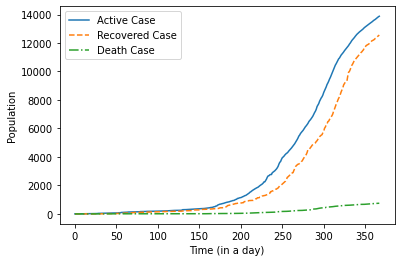

In [7]:
dk=cov_lampung_rapih.loc[:367,'akumulasi_kasus']
dataset = dk.values
TotKasus = dataset.astype('float32')
TotKasus = np.array(TotKasus.reshape(-1,1))

ds=cov_lampung_rapih.loc[:367,'akumulasi_sembuh']
dataset = ds.values
TotSembuh = dataset.astype('float32')
TotSembuh = np.array(TotSembuh.reshape(-1,1))

dm=cov_lampung_rapih.loc[:367,'akumulasi_meninggal']
dataset = dm.values
TotMeninggal = dataset.astype('float32')
TotMeninggal = np.array(TotMeninggal.reshape(-1,1))
 
plt.plot(TotKasus, label='Active Case')
plt.plot(TotSembuh,'--', label='Recovered Case')
plt.plot(TotMeninggal,'-.', label='Death Case') 
plt.xlabel('Time (in a day)')
plt.ylabel('Population')
plt.legend()
plt.show()

Before continue to next step, i will introduce about some function that we will use, there are :

- matriks( ), this function divide data into X and Y that contain lookback, both data shaped as array.

In [8]:
def matriks(data_arr, look_back):
  X, Y =[], []
  for i in range(len(data_arr)-look_back):
    d=i+look_back  
    X.append(data_arr[i:d])
    Y.append(data_arr[d])
 
  X = np.array(X)
  Y = np.array(Y)
  
  return X, Y

- hoho( ), this function separate both data before, X and Y, to data train and data test. So, until here we will have 4 data for each case.

In [9]:
def hoho (rand,lookback): 
  s = int(len(rand)*0.8) 
  x, y = matriks(rand, look_back) 
  x = np.reshape(x, (x.shape[0], 1, x.shape[1])) 
  xTrain , yTrain,xTest,yTest= x[0:s,:],y[0:s,:], x[s:,:],y[s:,:]
  
  return xTrain , yTrain,xTest, yTest

- scale_invers( ), this function has two output, first scaling data between 0 and 1, second restore data to real data.

In [10]:
def scale_invers (kasus,model):
  scaler =MinMaxScaler(feature_range=(0,1))
  rand=scaler.fit_transform(kasus)
  r = scaler.inverse_transform(model)
  return rand,r

- model_loss( ), this function will plot loss data. The smaller loss , the smaller the loss the better the model. 

In [11]:
def model_loss(history,case):
    
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    #plt.title('model loss'+ str(case))
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.savefig('loss.png', dpi=100)
    plt.show();

# Step 3 - Preparing Model
This section, we prepare architecture of RNN. Besides that, we use MSE as loss function and 'adam' as optimizer with lookback as much as 5. We use 1 input layer with  5 neuron, 3 hidden layer with 50, 25 and 20 neuron for each layer, and 1 output layer. so far, I have not found a standard rule regarding many neurons in the model in order to get the result
optimal, then in this study it is determined to select several many neurons then compare the results of the model obtained optimal.

In [12]:
look_back =5

model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(units=50, input_dim=look_back, activation='relu')) #Hiden layer 1
model.add(tf.keras.layers.Dense(25, activation='relu')) 
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(1)) #output
model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
  

# Step 4 - Data Normalization
In this section we use functions that we made before. First, scaling data. And then, we separate data.  

As example, we just use one case that is Death Case. From this section until last section we use that case. If all done, we can change the case with another case. At least, that what i was done.

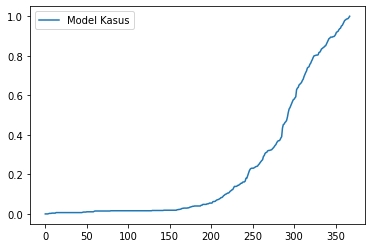

In [13]:
randKasus,rKasus=scale_invers(TotMeninggal,TotMeninggal)
plt.plot(randKasus, label='Model Kasus')
plt.legend()
plt.show()

In [14]:
xTrain ,yTrain, xTest, yTest = hoho(randKasus,look_back)

# Step 5 - Training Model
This section did after we separate both X and Y data to train and test data for each data. We use several epoch for fitting the model to find the model. Finally, we use epoch 100 because not too little and too much neither. so far I have not found a standard rule regarding many epoch in the model in order to get the result optimal, then in this study it is determined to select several many epoch then
compare the results of the model obtained optimal.

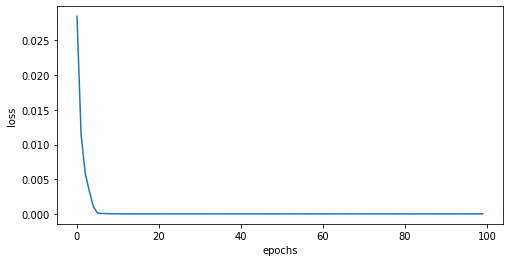

In [15]:
history1 = model.fit(xTrain, yTrain, epochs=100,verbose=0)
model_loss(history1,' Aktif')

# Step 6 - Prediction

In [16]:
trainPredictKasus = model.predict(xTrain)
testPredictKasus = model.predict(xTest)

In [17]:
trainScore = np.sqrt(np.mean(yTrain[:,0] - trainPredictKasus[:,0])**2)
print('Train Score Kasus: %.7f RMSE'%(trainScore))
testScore = np.sqrt(np.mean(yTest[:,0] - testPredictKasus[:,0])**2)
print('Test Score Kasus: %.7f RMSE'%(testScore))

Train Score Kasus: 0.0021276 RMSE
Test Score Kasus: 0.0037396 RMSE


In [18]:
akurasi_train = (1-trainScore)*100
akurasi_test = (1-testScore)*100
print('Accuracy Train Score Kasus: %.7f'%(akurasi_train)+'%')
print('Accuracy Test Score Kasus: %.7f'%(akurasi_test)+'%')

Accuracy Train Score Kasus: 99.7872394%
Accuracy Test Score Kasus: 99.6260434%


In [19]:
rand, trainPredictKasus = scale_invers(TotMeninggal,trainPredictKasus)
rand, yTrain = scale_invers(TotMeninggal,yTrain)
rand, testPredictKasus =scale_invers(TotMeninggal,testPredictKasus)
rand, yTest = scale_invers(TotMeninggal,yTest)
 
rr, rrr =scale_invers(TotMeninggal,randKasus)


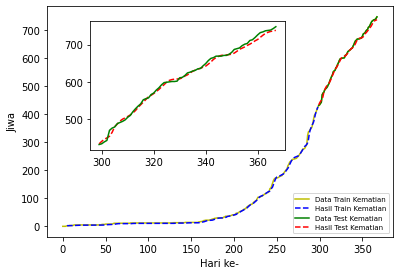

In [21]:
t = np.arange(len(randKasus))
fig= plt.figure()
axes1 = fig.add_axes([0.15,0.15,0.8,0.8])
axes2 = fig.add_axes([0.25,0.45,0.45,0.45])
axes1.plot(rrr, '-y',
           t[look_back:len(trainPredictKasus)+look_back],trainPredictKasus,'--b',        
           t[len(trainPredictKasus)+look_back:], yTest,'-g',       
           t[len(trainPredictKasus)+look_back:], testPredictKasus,'--r' 
           ) 
axes2.plot(t[len(trainPredictKasus)+look_back:], testPredictKasus,'--r',
           t[len(trainPredictKasus)+look_back:],yTest,'-g')
axes1.set_ylabel('Jiwa')
axes1.set_xlabel('Hari ke-')
axes1.legend(['Data Train Kematian', 'Hasil Train Kematian', 'Data Test Kematian','Hasil Test Kematian'], 
             loc='lower right', fontsize=7)
plt.savefig('rnnmodel.png', dpi=300 )


The plot above show us about RNN prediction model with 5 look back and several parameter tuning that good enough for predictions. So from this architecture of RNN we can use for prediction the case for several days ago.   

# In other way
I make simple code in other way to prediction without RNN but i think this code should be improve. 

In [22]:
t = np.arange(len(randKasus))
dk=cov_lampung_rapih.loc[:367,'akumulasi_meninggal']
dk=dk.values
dk = dk.reshape(-1,1)
dk[-1]

array([748])

In [23]:
mmscaler = MinMaxScaler(feature_range=(0, 1))
last_sms_scaled = mmscaler.fit_transform(dk[-look_back:])

X_test = []
X_test.append(last_sms_scaled)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[0],look_back))

pred_smp = model.predict(X_test)
pred_smp_unscaled = mmscaler.inverse_transform(pred_smp)

smp_today = round(dk.ravel()[-1], 0)
predicted_smp = round(pred_smp_unscaled.ravel()[0], 0)

print(f'Jumlah Kasus Kematian Terbaru :{smp_today}')
print(f'Prediksi Jumlah Kasus Kematian Satu hari ke Depan : {predicted_smp}')


Jumlah Kasus Kematian Terbaru :748
Prediksi Jumlah Kasus Kematian Satu hari ke Depan : 742.0
